In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

In [2]:
# --- Offers Dataset
# TODO: change the offers dataset to one different from Turing Careers
with sqlite3.connect('./datasets/offers_dataset.db') as offers_conn:
    offers_frame = pd.read_sql('SELECT * FROM Offers', offers_conn, index_col='ID')

offers_frame

,Name,Description,Language,LocationType,Location
ID,,,,,
1,Software Developer - AI Trainer (Contract),We are looking for proficientprogrammersto joi...,Italian,Remote,None
2,"Software Developer Java, C++ o C# a Padova","Brain Tree Srl, azienda di consulenza informat...",Italian,On-Site,"Padova, Veneto"
3,Ingegnere Software Applicativo,Avio è un'azienda leader nella propulsione spa...,Italian,On-Site,00034 Lazio
4,Deloitte NextHub Bari – Software Developer - J...,Deloitte NextHub Bari – Software Developer - J...,Italian,On-Site,"Bari, Puglia"
5,Remote Senior Wordpress Developer - Fluent in ...,The Role:We are looking for aSeniorWordPress d...,Italian,Remote,None
...,...,...,...,...,...
692,Eltek Systems - Senior Control Systems Softwar...,Eltek Systems are looking to recruit Senior So...,Italian,On-Site,Peterborough
693,Senior UI Programmer - AAA Project - Remote,Senior UI Programmer - AAA Project - RemoteFul...,Italian,On-Site,Newcastle upon Tyne
694,Software Engineer (C++) – HP Wolf Security,The primary focus of the HP Wolf Security team...,Italian,On-Site,Cambridge CB1


In [3]:
# --- Skills Dataset
with sqlite3.connect('./datasets/skills_short.db') as skills_conn:
    skills_frame = pd.read_sql('SELECT * FROM Skills', skills_conn, index_col='ID')
    
skills_frame

,Skill
ID,
1,JavaScript
2,HTML
3,Python
4,SQL
5,TypeScript
...,...
74,Deno
75,Gatsby
77,Phoenix


## Offers skill extraction

In [4]:
from utils import print_performance


@print_performance
def extract_skills(offers_df, skills_df):
    skill_list = [skill.lower() for skill in skills_df['Skill'].tolist()]
    skill_vectors = []
    for skill in skill_list:
        presence_vector = offers_df.Description.map(lambda desc: skill in desc.lower()).rename(skill)
        skill_vectors.append(presence_vector)
    return pd.concat([vec for vec in skill_vectors], axis=1)   

In [5]:
skill_vector = extract_skills(offers_frame, skills_frame)
skill_vector

Done in 1.52


,javascript,html,python,sql,typescript,bash,java,c#,c++,c,...,angularjs,svelte,ruby on rails,next.js,symfony,deno,gatsby,phoenix,solid.js,css
ID,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
5,True,True,False,True,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
693,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
694,True,True,True,False,True,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False


## Distribution Analysis
Given that the dataset is imbalanced more data/better data should be acquired

In [6]:
skills_headers = skill_vector.columns.tolist()
skills_headers.remove('c')
skills_headers.remove('r')
skills_headers.remove('go')
skill_vector = skill_vector[skills_headers]

In [7]:
# --- Given the imbalanced nature drop some of the most common ones
#     dropping rows will decrease the frequency of others too.
skill_counts = skill_vector.sum()

In [8]:
def plot_skills(count_frame):
    plt.figure(figsize=(10, 22))
    sns.barplot(x=count_frame.values, y=count_frame.index, palette="viridis")
    plt.title("Distribution of Skills in the Dataset")
    plt.xlabel("Count")
    plt.ylabel("Skills")
    plt.show()

C:\Users\anton\AppData\Local\Temp\ipykernel_7144\1933005626.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_frame.values, y=count_frame.index, palette="viridis")


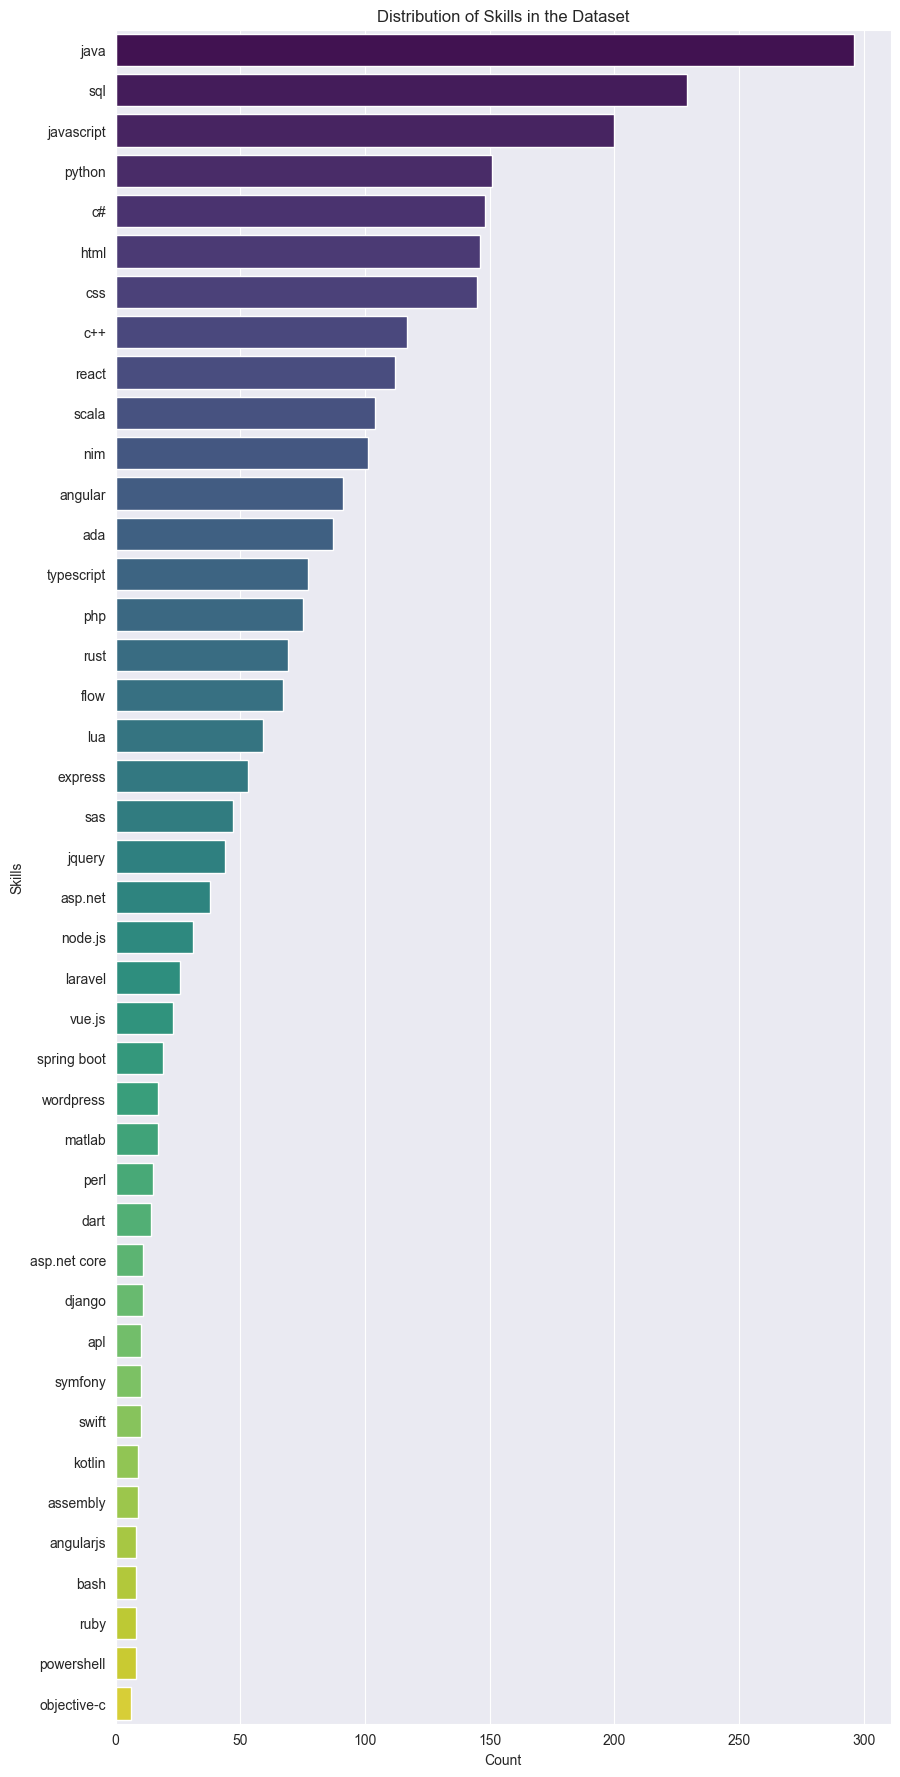

In [9]:
selected_skills = skill_counts[skill_counts >= 6].index
skill_vector = skill_vector[selected_skills]
skill_counts = skill_vector.sum()

plot_skills(skill_counts.sort_values(ascending=False))

## Association rule mining

### FP max Algorithm
One red-flag is that it doesn't show a single item set with HTML and CSS together.

In [10]:
from mlxtend.frequent_patterns import fpmax

@print_performance
def task_fp_max(vect):
    return fpmax(vect, use_colnames=True, min_support=0.111)

In [11]:
skill_sets = task_fp_max(skill_vector)
skill_sets

Done in 0.01


,support,itemsets
0,0.125000,(ada)
1,0.130747,(angular)
2,0.145115,(nim)
3,0.149425,(scala)
4,0.117816,"(java, react)"
5,0.168103,(c++)
6,0.160920,"(java, javascript, html, css)"
7,0.112069,"(java, c#)"
8,0.114943,"(c#, sql)"
9,0.216954,(python)


## Clustering Algorithm

## Export

In [12]:
with sqlite3.connect('./datasets/skill_sets.db') as out_conn:
    out_curs = out_conn.cursor()
    out_curs.execute('''
        CREATE TABLE IF NOT EXISTS SkillSets (
            ID INTEGER PRIMARY KEY,
            SKILLS TEXT
        )    
    ''')

    i = -1
    for skill_set in skill_sets['itemsets'].tolist():
        if len(skill_set) > 1: 
            skill_list = []
            
            for skill in skill_set:
                skill_list.append(skill)
                
            i += 1
            out_curs.execute('''INSERT INTO SkillSets VALUES (?, ?)''', (i, ', '.join(skill_list)))
            
    out_conn.commit()


In [13]:
with sqlite3.connect('./datasets/skill_sets.db') as test_conn:
        test_frame = pd.read_sql('SELECT * FROM SkillSets', test_conn, index_col='ID')

test_frame

,SKILLS
ID,
0,"java, react"
1,"java, javascript, html, css"
2,"java, c#"
3,"c#, sql"
4,"java, javascript, sql"
